# GACSE Workshop

In [1]:
from __future__ import print_function

In [2]:
import sys
sys.path.append('../build/')

In [3]:
%pylab inline
np.set_printoptions(precision=4, suppress=True)


Populating the interactive namespace from numpy and matplotlib


In [4]:
import versor as vsr

In [5]:
from motor_estimation import MotorEstimationSolver
from motor_estimation_valkenburg_dorst import (point_matrix, dual_line_matrix, dual_plane_matrix)

In [6]:
fig_width_pt =  332.89726               # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (sqrt(5.0)-1.0)/2.0       # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size = [fig_width,fig_height]
params = {
    'axes.labelsize': 9,
    'font.size': 9,
    "font.family": "serif",
    "font.serif": [],
    'legend.fontsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'text.latex.preamble':[r'\usepackage{amsmath}', r'\usepackage{bm}'],
    'figure.figsize': fig_size,
    'axes.linewidth': 0.5
}
matplotlib.rcParams.update(params)

## Valkenburg-Dorst Solver

In [7]:
class VDMotorEstimationSolver(object):
    def __init__(self):
        self._point_matrix = np.zeros((8,8))
        self._dual_line_matrix = np.zeros((8,8))
        self._dual_plane_matrix = np.zeros((8,8))
        
    @property
    def L(self):
        return self._point_matrix + self._dual_line_matrix + self._dual_plane_matrix
    
    def add_point_observations(self, ps, qs):
        for p, q in zip(ps,qs):
            self._point_matrix += point_matrix(p,q)
    
    def add_dual_line_observations(self,ps,qs):
        for p, q in zip(ps,qs):
            self._dual_line_matrix += dual_line_matrix(p,q)
    
    def add_dual_plane_observations(self, ps,qs):
        for p, q in zip(ps,qs):
            self._dual_plane_matrix += dual_plane_matrix(p,q)
        
    def solve(self):
        L = self.L
        Lrr = L[:4,:4]
        Lrq = L[:4,4:]
        Lqr = L[4:,:4]
        Lqq = L[4:,4:]
        Lp = Lrr - np.dot(Lrq, np.dot(np.linalg.pinv(Lqq), Lqr))
        w,v = np.linalg.eig(Lp)
        r = v[:,np.argmax(w)]
        q = np.dot(-np.dot(np.linalg.pinv(Lqq), Lqr),r)
        return vsr.Mot(*np.array([r,q]).ravel())  

## Ground truth motor

In [8]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
print(motor)

Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]


## Motor Estimation from Points

$$\min_{M \in \mathcal M} {1 \over 2} \sum_{i=1}^N \| \mathrm{P}_{\mathbb R_3^1}(M a_i \widetilde M) - \mathrm{P}_{\mathbb R_3^1}(b_i )  \|^2$$

### Dataset generation

In [9]:
n_points = 10
sigma = 0.09
points_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null() 
            for i in range(n_points)]
points_b = [point.spin(motor) for point in points_a]
points_b_noisy = [vsr.Vec(*(np.array(point)[:3] 
                            + sigma * np.random.randn(3))).null() 
                  for point in points_b]

### Estimate motor using local parameterization

In [51]:
# initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
initial_motor = vsr.Vec(2,3,4).trs() * vsr.Rot(vsr.Biv(0,-1,0) * np.pi/6)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(points_a, points_b):
    mes.add_point_correspondences_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(estimated_motor, summary_point_1) = mes.solve()
print(summary_point_1['full_report'])


Solver Summary (v 1.12.0-eigen-(3.2.92)-lapack-suitesparse-(4.4.6)-openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   30                       30

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1

Cost:
Initial                          9.698998e+01
Final              

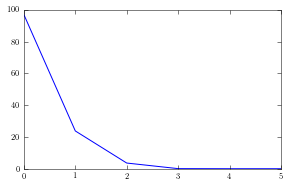

In [52]:
plt.plot([it['cost'] for it in summary_point_1['iterations'] ])

#### Check solution

In [12]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866  0.    -0.5   -0.    -0.683 -0.433 -0.183 -0.25 ]
True


### Estimate motor using Valkenburg-Dorst solver

In [13]:
vd = VDMotorEstimationSolver()
vd.add_point_observations(points_a, points_b)
vd_estimated_motor = vd.solve()

#### Check solution

In [14]:
print(np.array(motor))
print(np.array(vd_estimated_motor))
print(np.allclose(np.array(motor), np.array(vd_estimated_motor)))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866 -0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
True


## Motor Estimation from Lines

### Dataset generation

In [15]:
lines_a = [vsr.Dll(vsr.Vec(*np.random.normal(0.0,0.8,3)),
                   vsr.Vec(*np.random.normal(0.0,0.8,3)))
          for i in range(10)]
lines_b = [line.spin(motor) for line in lines_a]

### Estimate motor using 6 residuals

$$ \min_{M \in \mathcal M} \frac{1}{2} \sum_{i=1}^n \| M \varLambda_{b_i} \tilde{M} - \varLambda_{a_i} \|^2 $$

In [16]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
print(motor)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_correspondences_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
# mes.gradient_tolerance = 1e-16
# mes.parameter_tolerance = 1e-16
estimated_motor, lin_summary_1 = mes.solve()
print(lin_summary_1['full_report'])


Solver Summary (v 1.12.0-eigen-(3.2.92)-lapack-suitesparse-(4.4.6)-openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   60                       60

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1

Cost:
Initial                          4.000154e+01
Final              

#### Check solution

In [17]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866 -0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
True


### Estimate motor using 4 residuals

In [18]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_angle_distance_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
estimated_motor, lin_summary_2 = mes.solve()
print(lin_summary_2['full_report'])


Solver Summary (v 1.12.0-eigen-(3.2.92)-lapack-suitesparse-(4.4.6)-openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   40                       40

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1

Cost:
Initial                          4.121952e+01
Final              

#### Check solution

In [19]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))
print(np.allclose(np.array(motor), np.array(estimated_motor), 
                  rtol=1e-05, atol=1e-03))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.8662 -0.0001 -0.4996  0.0001 -0.6836 -0.4331 -0.1832 -0.2498]
False
True


### Estimate motor using 2 residuals

In [20]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_angle_distance_norm_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
estimated_motor, lin_summary_3 = mes.solve()
print(lin_summary_3['full_report'])


Solver Summary (v 1.12.0-eigen-(3.2.92)-lapack-suitesparse-(4.4.6)-openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   20                       20

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1

Cost:
Initial                          4.121952e+01
Final              

#### Check solution

In [21]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))
print(np.allclose(np.array(motor), np.array(estimated_motor), 
                  rtol=1e-05, atol=1e-03))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
False
True


### Estimate motor using Valkenburg-Dorst solver

In [22]:
vd = VDMotorEstimationSolver()
vd.add_dual_line_observations(lines_a, lines_b)
vd_estimated_motor = vd.solve()
print(vd_estimated_motor)

Mot: [ 0.87 2.4e-17 -0.5 1.3e-17 0 0 0 0 ]


#### Check solution

In [23]:
print(np.array(motor))
print(np.array(vd_estimated_motor))
print(np.allclose(motor, vd_estimated_motor))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866  0.    -0.5    0.     0.     0.     0.     0.   ]
False


### Plots

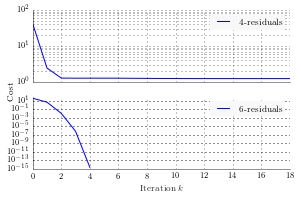

In [26]:
fig, ax = plt.subplots(2, sharex=True)

ax[0].set_aspect('equal')
plt.set_cmap('gray')

almost_black = '#262626'
spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax[0].spines[spine].set_visible(False)
    ax[1].spines[spine].set_visible(False)
    
ax[0].xaxis.set_ticks_position('none')
ax[0].yaxis.set_ticks_position('none')
ax[1].xaxis.set_ticks_position('none')
ax[1].yaxis.set_ticks_position('none')

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax[0].spines[spine].set_linewidth(0.5)
    ax[0].spines[spine].set_color(almost_black)
    ax[1].spines[spine].set_linewidth(0.5)
    ax[1].spines[spine].set_color(almost_black)
ax[0].xaxis.label.set_color(almost_black)
ax[0].yaxis.label.set_color(almost_black)
ax[1].xaxis.label.set_color(almost_black)
ax[1].yaxis.label.set_color(almost_black)

# ax.plot([it['cost'] for it in lin_summary_4['iterations'] ], label=r"commutator")
# ax[0].plot([it['cost'] for it in lin_summary_3['iterations'] ], label=r"$2$-residuals", c='red')
ax[0].plot([it['cost'] for it in lin_summary_2['iterations'] ], label=r"$4$-residuals")
ax[1].plot([it['cost'] for it in lin_summary_1['iterations'] ], label=r"$6$-residuals")

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].grid(which="both")
ax[1].grid(which="both")

# ax[0].set_xscale('log')

# plt.yscale('log')

# ax[0].title.set_color(almost_black)
# ax[0].axhline(0, color=almost_black, linewidth=0.15)
# ax[0].axvline(0, color=almost_black, linewidth=0.15)
# ax[1].title.set_color(almost_black)
# ax[1].axhline(0, color=almost_black, linewidth=0.15)
# ax[1].axvline(0, color=almost_black, linewidth=0.15)

# Remove the line around the legend box, and instead fill it with a light grey
# Also only use one point for the scatterplot legend because the user will 
# get the idea after just one, they don't need three.
light_grey = np.array([float(248)/float(255)]*3)
legend = ax[0].legend(frameon=True, scatterpoints=1)
rect = legend.get_frame()
rect.set_facecolor(light_grey)
rect.set_linewidth(0.0)
legend = ax[1].legend(frameon=True, scatterpoints=1)
rect = legend.get_frame()
rect.set_facecolor(light_grey)
rect.set_linewidth(0.0)

fig.text(0.06, 0.5, 'Cost', ha='center', va='center', rotation='vertical')

# plt.tight_layout()
plt.xlabel(r'Iteration $k$')
# fig.ylabel(r'Cost')
# ax[1].ylabel(r'Cost')

# plt.savefig('/home/lars/Dropbox/Apps/ShareLaTeX/2016-gacse/figures/cost_lines2.pdf')

## Motor Estimation from planes

### Dataset generation

In [27]:
n_planes = 10
planes_a = []
for i in range(10):
    dir_vec = np.random.normal(0.0, 0.8, 4)
    dir_vec = dir_vec / np.linalg.norm(dir_vec)
    distance = np.random.normal(0.0, 0.8,1)
    arr = dir_vec + distance
    planes_a.append(vsr.Dlp(dir_vec[0],dir_vec[1],dir_vec[2],distance[0]))
planes_b = [plane.spin(motor) for plane in planes_a]

### Estimate motor using 2 residuals

In [28]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
noise_motor_plane = vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/24)
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(planes_a, planes_b):
#     mes.add_dual_plane_angle_error_residual_block(a,b.spin(noise_motor_plane))
    mes.add_dual_plane_angle_error_residual_block(a,b)

mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
mes.function_tolerance = 1e-8
mes.max_num_iterations = 100
estimated_motor, pln_summary_1 = mes.solve()
print(pln_summary_1['brief_report'])

Ceres Solver Report: Iterations: 25, Initial cost: 3.685728e+01, Final cost: 1.250000e+00, Termination: CONVERGENCE


In [29]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))
print(np.allclose(np.array(motor), np.array(estimated_motor), 
                  rtol=1e-05, atol=1e-03))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866 -0.    -0.5   -0.    -0.683 -0.433 -0.183 -0.25 ]
False
True


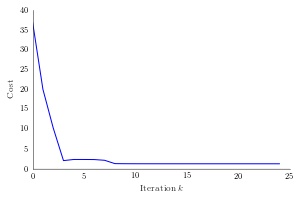

In [30]:
fig, ax = plt.subplots(1)

# ax.set_aspect('equal')
plt.set_cmap('gray')

almost_black = '#262626'
spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)
    ax.spines[spine].set_color(almost_black)
ax.xaxis.label.set_color(almost_black)
ax.yaxis.label.set_color(almost_black)

ax.plot([it['cost'] for it in pln_summary_1['iterations'] ])

ax.title.set_color(almost_black)
ax.axhline(0, color=almost_black, linewidth=0.15)
ax.axvline(0, color=almost_black, linewidth=0.15)

# Remove the line around the legend box, and instead fill it with a light grey
# Also only use one point for the scatterplot legend because the user will 
# get the idea after just one, they don't need three.

# light_grey = np.array([float(248)/float(255)]*3)
# legend = ax.legend(frameon=True, scatterpoints=1)
# rect = legend.get_frame()
# rect.set_facecolor(light_grey)
# rect.set_linewidth(0.0)

plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')


# plt.savefig('/Users/lars/Dropbox/Apps/ShareLaTeX/2016-gacse/figures/cost_planes.pdf')

### Estimate motor using Valkenburg-Dorst solver

In [31]:
vd = VDMotorEstimationSolver()
vd.add_dual_plane_observations(planes_a, planes_b)
vd_estimated_motor = vd.solve()
print(vd_estimated_motor)

Mot: [ 0.87 -2.5e-18 -0.5 5.2e-18 0 0 0 0 ]


#### Check solution

In [32]:
print(np.array(motor))
print(np.array(vd_estimated_motor))
print(np.allclose(motor, vd_estimated_motor))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866 -0.    -0.5    0.     0.     0.     0.     0.   ]
False


## Motor Estimation from heterogeneous conformal objects

In [64]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
noise_motor = vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/100)

noise_motor_plane = vsr.Vec(0.05,0.05,0.05).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/100)
noise_motor_lines = vsr.Vec(-0.01,-0.01,-0.01).trs() * vsr.Rot(vsr.Biv(0,1,0) * (-np.pi/100))
noise_motor_points = vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(0,0,1) * (np.pi/100))

# initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

initial_motors = [vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
                  vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,-1,0) * np.pi/6.0),
                  vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/5.0),
                  vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(1,1,1).unit() * np.pi/4.0)]


summaries = []
estimated_motors = []
for initial_motor in initial_motors:
    mes = MotorEstimationSolver(initial_motor)
    for a, b in zip(planes_a, planes_b):
        mes.add_dual_plane_angle_error_residual_block(a,b)
    for a, b in zip(lines_a, lines_b):
        mes.add_line_correspondences_residual_block(a,b)
    for a, b in zip(points_a, points_b):
        mes.add_point_correspondences_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = "DENSE_QR"
    mes.max_num_iterations = 100
    em, summary_het = mes.solve()
    estimated_motors.append(em)
    summaries.append(summary_het)
    print(initial_motor)
    print(motor)
    print(em)
    print(np.array(motor))
    print(np.array(estimated_motor))
    print(np.allclose(np.array(motor), np.array(estimated_motor)))
    print(np.allclose(np.array(motor), np.array(estimated_motor), 
                      rtol=1e-05, atol=1e-5))
    print(summary_het['brief_report'])

Mot: [ 1 0 0 0 0 0 0 0 ]
Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]
Mot: [ 0.87 -8.1e-06 -0.5 -3.7e-07 -0.68 -0.43 -0.18 -0.25 ]
[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866 -0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
True
True
Ceres Solver Report: Iterations: 4, Initial cost: 9.570133e+01, Final cost: 1.250000e+00, Termination: CONVERGENCE
Mot: [ 0.87 0 0.5 0 -0.18 -0.43 -0.68 0.25 ]
Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]
Mot: [ 0.87 -4.3e-05 -0.5 -2.7e-05 -0.68 -0.43 -0.18 -0.25 ]
[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866 -0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
True
True
Ceres Solver Report: Iterations: 5, Initial cost: 1.861461e+02, Final cost: 1.250001e+00, Termination: CONVERGENCE
Mot: [ 0.81 0 -0.59 0 -0.7 -0.4 -0.11 -0.29 ]
Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]
Mot: [ 0.87 3e-06 -0.5 1.8e-05 -0.68 -0.43 -0.18 -0.25 ]
[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866 -0.    -0.5    0

[]

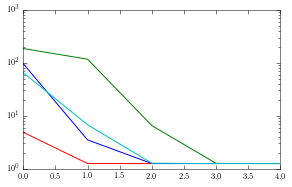

In [66]:
for s in summaries:
    plt.plot([it['cost'] for it in s['iterations']])
plt.semilogy()

### Estimate motor using Valkenburg-Dorst solver

In [34]:
vd = VDMotorEstimationSolver()
vd.add_point_observations(points_a, points_b)
vd.add_dual_line_observations(lines_a, lines_b)
vd.add_dual_plane_observations(planes_a, planes_b)
vd_estimated_motor = vd.solve()
print(vd_estimated_motor)

Mot: [ -0.87 1e-17 0.5 5.8e-18 0.68 0.43 0.18 0.25 ]


#### Check solution

In [35]:
print(np.array(motor))
print(np.array(vd_estimated_motor))
print(np.allclose(motor, vd_estimated_motor))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[-0.866  0.     0.5    0.     0.683  0.433  0.183  0.25 ]
False


## With noise

In [75]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
noise_motor = vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/100)

noise_motor_planes = vsr.Vec(0.05,0.05,0.05).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/100)
noise_motor_lines = vsr.Vec(-0.01,-0.01,-0.01).trs() * vsr.Rot(vsr.Biv(0,1,0) * (-np.pi/100))
noise_motor_points = vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(0,0,1) * (np.pi/100))

points_b_noisy = [b.spin(noise_motor_points) for b in points_b]
lines_b_noisy = [b.spin(noise_motor_lines) for b in lines_b]
planes_b_noisy = [b.spin(noise_motor_planes) for b in planes_b]

In [74]:
d = [[np.linalg.norm(np.array(a.spin(em)) - 
                np.array(a.spin(motor))) for a in points_a] for em in estimated_motors]
for d in d:
    print(np.mean(d), np.std(d))

0.151254275972 0.0217815740662
0.151145910668 0.0217787451814
0.150866467394 0.021763944312
0.150677449438 0.0217597446267


[]

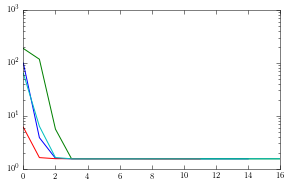

In [68]:
for s in summaries:
    plt.plot([it['cost'] for it in s['iterations']])
plt.semilogy()

### Estimate motor using Valkenburg-Dorst solver

In [38]:
vd = VDMotorEstimationSolver()
vd.add_point_observations(points_a, points_b_noisy)
vd.add_dual_line_observations(lines_a, lines_b_noisy)
vd.add_dual_plane_observations(planes_a, planes_b_noisy)
vd_estimated_motor = vd.solve()
print(vd_estimated_motor)

Mot: [ 0.87 0.0013 -0.49 -0.014 -0.76 -0.46 -0.23 -0.25 ]


#### Check solution

In [39]:
print(np.array(motor))
print(np.array(vd_estimated_motor))
print(np.allclose(motor, vd_estimated_motor))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.8701  0.0013 -0.4926 -0.0139 -0.7608 -0.457  -0.2255 -0.247 ]
False


In [86]:
d = [np.linalg.norm(np.array(a.spin(vd_estimated_motor)) - np.array(a.spin(motor))) for a in points_a]
print(np.mean(d), np.std(d))

0.384966861964 0.0892294693919


In [87]:
initial_motors = [vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
                  vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,-1,0) * np.pi/6.0),
                  vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/5.0),
                  vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(1,1,1).unit() * np.pi/4.0),
                  vd_estimated_motor]
summaries = []
estimated_motors = []
for initial_motor in initial_motors:
    mes = MotorEstimationSolver(initial_motor)
    for a, b in zip(planes_a, planes_b_noisy):
        mes.add_dual_plane_angle_error_residual_block(a,b)
    for a, b in zip(lines_a, lines_b_noisy):
        mes.add_line_correspondences_residual_block(a,b)
    for a, b in zip(points_a, points_b_noisy):
        mes.add_point_correspondences_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = "DENSE_QR"
    mes.max_num_iterations = 100
    em, summary_het = mes.solve()
    estimated_motors.append(em)
    summaries.append(summary_het)
    print(np.array(initial_motor))
    print(np.array(motor))
    print(np.array(em))
    print(summary_het['brief_report'])

[ 1.  0.  0.  0.  0.  0.  0.  0.]
[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.8709 -0.0099 -0.4913 -0.0118 -0.7153 -0.449  -0.1892 -0.2415]
Ceres Solver Report: Iterations: 15, Initial cost: 9.891618e+01, Final cost: 1.539053e+00, Termination: CONVERGENCE
[ 0.866  0.     0.5    0.    -0.183 -0.433 -0.683  0.25 ]
[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.8709 -0.0098 -0.4913 -0.0118 -0.7153 -0.449  -0.1892 -0.2415]
Ceres Solver Report: Iterations: 17, Initial cost: 1.864911e+02, Final cost: 1.539052e+00, Termination: CONVERGENCE
[ 0.809   0.     -0.5878  0.     -0.6984 -0.4045 -0.1106 -0.2939]
[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.8708 -0.0098 -0.4913 -0.0118 -0.7153 -0.449  -0.1891 -0.2415]
Ceres Solver Report: Iterations: 12, Initial cost: 6.080675e+00, Final cost: 1.539051e+00, Termination: CONVERGENCE
[ 0.7071 -0.4082 -0.4082 -0.4082 -0.7618 -0.3536  0.0547  0.2041]
[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 

[]

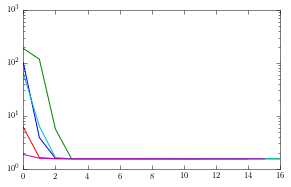

In [88]:
for s in summaries:
    plt.plot([it['cost'] for it in s['iterations']])
plt.semilogy()

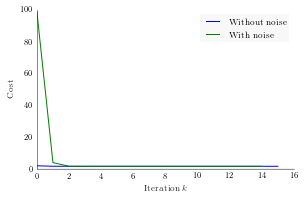

In [80]:
fig, ax = plt.subplots(1)

# ax.set_aspect('equal')
plt.set_cmap('gray')

almost_black = '#262626'
spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)
    ax.spines[spine].set_color(almost_black)
ax.xaxis.label.set_color(almost_black)
ax.yaxis.label.set_color(almost_black)

ax.plot([it['cost'] for it in summary_het['iterations'] ], label="Without noise")
ax.plot([it['cost'] for it in summary_het_noise['iterations']], label="With noise")

# ax.set_yscale('log')

ax.title.set_color(almost_black)
ax.axhline(0, color=almost_black, linewidth=0.15)
ax.axvline(0, color=almost_black, linewidth=0.15)

# Remove the line around the legend box, and instead fill it with a light grey
# Also only use one point for the scatterplot legend because the user will 
# get the idea after just one, they don't need three.

light_grey = np.array([float(248)/float(255)]*3)
legend = ax.legend(frameon=True, scatterpoints=1)
rect = legend.get_frame()
rect.set_facecolor(light_grey)
rect.set_linewidth(0.0)

plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')


# plt.savefig('/Users/lars/Dropbox/Apps/ShareLaTeX/2016-gacse/figures/cost_heterogeneous.pdf')